### Data exploring

<font size="4"> Let's look at the data without any preprocesses steps, if we are lucky enough, we may find something interesting
</font>

In [75]:
!pip install pandas
!pip install seaborn
!pip install matplotlib
!pip install wordcloud
!pip install nltk

     |████████████████████████████████| 366 kB 1.2 MB/s eta 0:00:01


In [29]:
import pandas as pd
import seaborn as sns, numpy as np
sns.set_theme(); np.random.seed(0)
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
import urllib3.request

In [2]:
df = pd.read_json("../data/all-issues-with-stats.json")

<font size="4">
let's try select set of fields, that we think can help us and look at the report 
</font>

### First hypothesis
<font size="4">
we have enough datapoints in labels field if so, the task can be solved as the classification one
</font>

In [3]:
import json
with open('all-issues.json') as file:
    data = json.load(file)

In [4]:
label_list = [issue['labels'] for issue in data['issues'] if 'labels' in issue]
label_dataset = []
for labels in label_list:
     label_dataset.append([label['name'] for label in labels if 'name' in label])
df = pd.DataFrame(label_dataset)

### Results of the investigating of first hypothesis

In [5]:
print('1. Number of datapoints:', df.shape[0])
print('2. Number of datapoints with at least one tag:', df.shape[0] -  df[0].isnull().sum())
print('3. Number of datapoints with at least 2 tags', df.shape[0] - df[1].isnull().sum())

1. Number of datapoints: 5661
2. Number of datapoints with at least one tag: 3429
3. Number of datapoints with at least 2 tags 2311


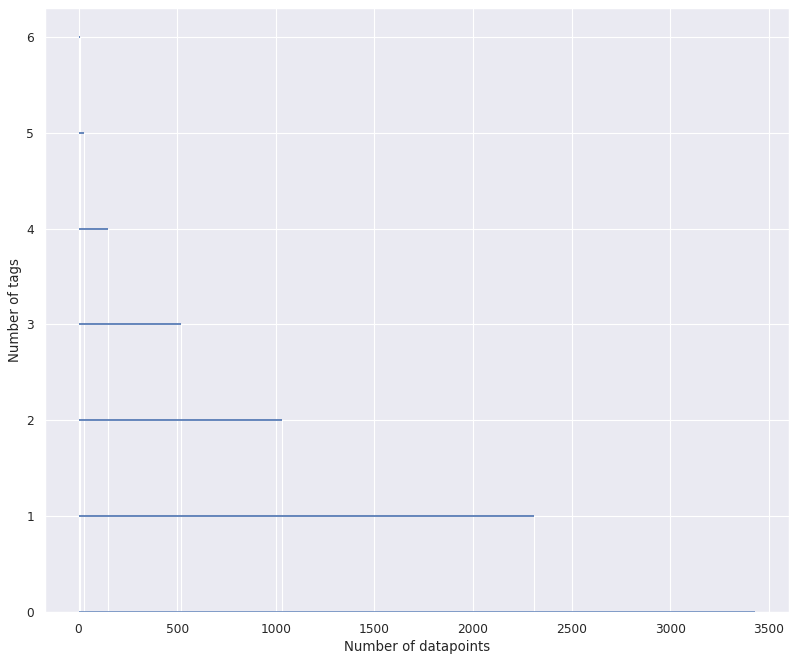

In [6]:
x = [df.shape[0] - df[i].isnull().sum() for i in range(7)]

plt.figure(figsize=(12, 10), dpi=80)
plt.bar(x,[i for i in range(7)],align='center') 
plt.xlabel('Number of datapoints')
plt.ylabel('Number of tags')
for i in range(7):
    plt.hlines(i,0,x[i])
plt.show()

<font size="4">
So we have pretty huge number of datapoints with at least one tag. But are they really helpful? I mean, is this label truly display severity of the puzzle?
</font>

In [7]:
import itertools

In [8]:
tags = [tag for tag in list(itertools.chain(*[list(df[i]) for i in range(7)])) if not pd.isnull(tag)]
tags_text = ' '.join(tags)
word_cloud = WordCloud(width=1800, height=1200,collocations = False, background_color = 'white').generate(tags_text)

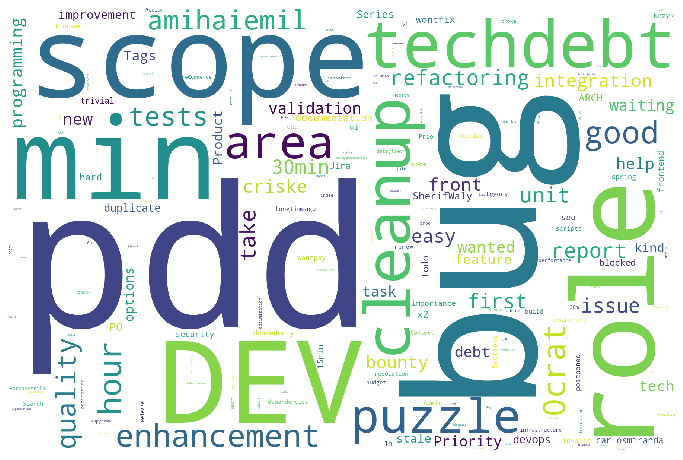

In [9]:
plt.figure(figsize=(12, 10))
plt.imshow(word_cloud, interpolation='nearest')
plt.axis("off")
plt.show()

In [10]:
word_dist = nltk.FreqDist(tags)
rslt=pd.DataFrame(word_dist.most_common(20),columns=['Word','Frequency'])

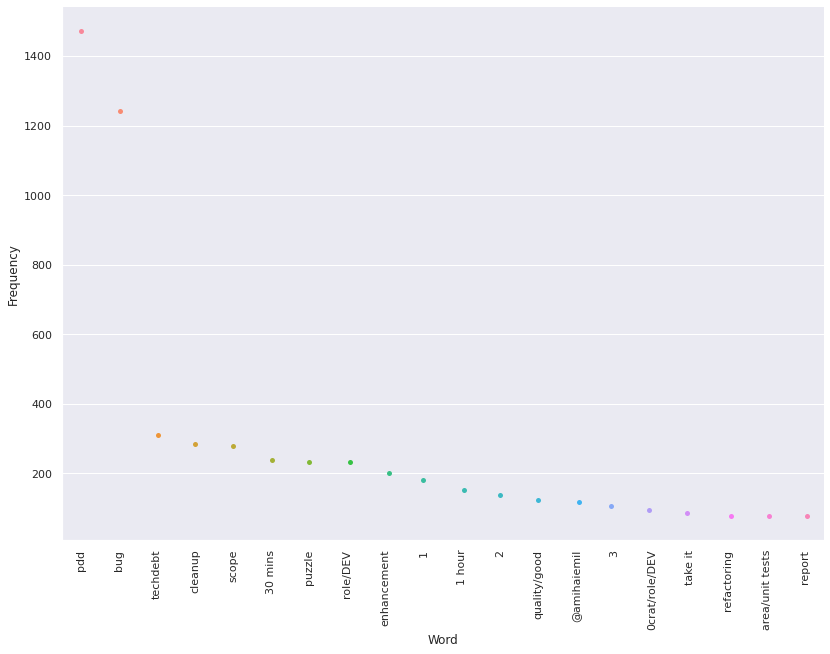

In [11]:
sns.catplot(x='Word', y='Frequency',data = rslt,height=8.27, aspect=11.7/8.27);
plt.xticks(rotation=90);

### From the observed data i can make several conclusion:
1. There are some good labels of puzzles, that actually contains information about severity of the bug, or the importance for the client, like: hour, easy, enhancement, first, documentation, techdebt. 
2. Most of the puzzles contains labels, which is not very relevant to the ranking task, for example can we understand the importance of task with label bug or pdd?

### As the conclusion for the first hypothesis, i propose to not to use the label field

### Second hypothesis: if task is hard, many puzzles will be created, so if we have a long series of related puzzles, we can think of it as a one feature that need to be implemented. Longer the puzzle chain, then more importantly will be head of the chain

In [12]:
df = pd.read_csv('all-puzzles.csv')
df['Parent ID'].isnull().sum()

10500

<font size="4">
All puzzles do not have parent data, which means that we do not have data of relation of puzzles
</font>

### At this moment, we can't use this approach

### Another approach

<font size="4">
If task is hard many people will be involved into this task, so we can predict the rating of the task, by predicting number of comments to the issue
</font>

In [58]:
with open('all-issues2.json') as f:
    comments_count = []
    data = json.loads(f.read())
    data = [issue for issue in data['issues'] if 'comments_url' in issue]
    for issue in data:
        comments_count.append(len(issue['comments_url']))

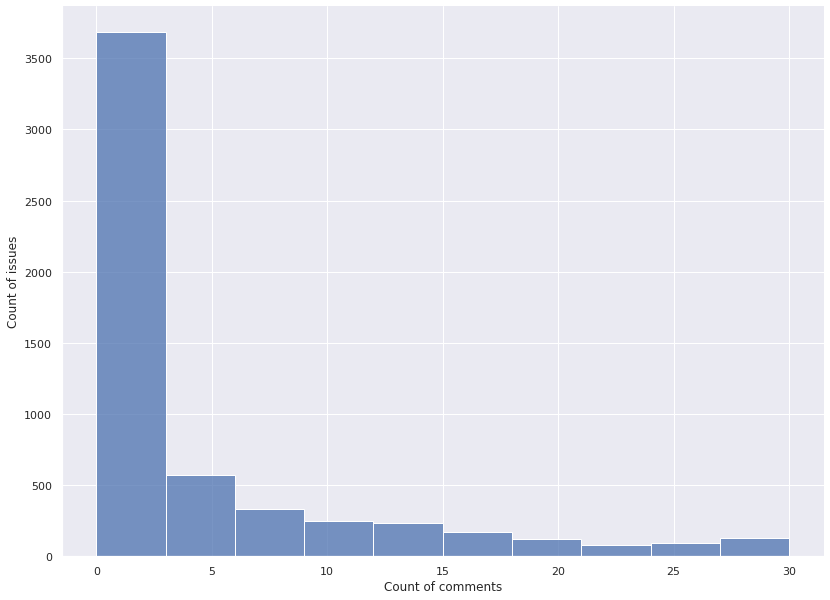

In [69]:
ax = sns.displot(comments_count,binwidth=3, height=8.27, aspect=11.7/8.27)
ax.set(xlabel='Count of comments', ylabel='Count of issues')

In [74]:
print('Count of issues where count of messages at least one: ', len(list(filter(lambda x: x >= 1,comments_count))))
print('Count of issues where count of messages is zero: ', len(list(filter(lambda x: x == 0, comments_count))))

Count of issues where count of messages at least one:  4517
Count of issues where count of messages is zero:  1144


<font size="4">
So even if we have very unbalanced data, where most of the issues have number of comments is less then 5, we could try this approach, when we predicting the rank of the puzzle, but predicting the count of comments 
</font>